In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = './data/engineered_data.csv'

In [3]:
df = pd.read_csv(data_dir)

df.head()

,Unnamed: 0,Unnamed: 0.1,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,0,0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,1,1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,2,2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,3,3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,4,4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000


In [6]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis='columns')
df.head()

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000


In [7]:
df.shape

(13218, 8)

### Outlier Removal

### 1. For real estate houses, there can be anamolies like the area(sqft) per bedroom can be in a certain range.

* The range can be learnt by domain knowledge or experts.
* *Assumption* can be made that any house having less than 300sqft area per bedroom is considered an outlier/anamoly
* Thus, it can be removed from dataset

In [8]:
threshold = 300

df[df['total_sqft']/df['bhk'] < threshold]

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,2.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,2.0,200.0,8,33333.333333
57,Murugeshpalya,6 Bedroom,1407.0,4.0,1.0,150.0,6,10660.980810
67,Devarachikkanahalli,8 Bedroom,1350.0,7.0,0.0,85.0,8,6296.296296
69,other,3 Bedroom,500.0,3.0,2.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...,...
13175,other,7 Bedroom,1400.0,7.0,2.0,218.0,7,15571.428571
13177,other,6 Bedroom,1200.0,5.0,2.0,130.0,6,10833.333333
13179,Margondanahalli,5 Bedroom,1375.0,5.0,1.0,125.0,5,9090.909091
13201,Vidyaranyapura,5 Bedroom,774.0,5.0,3.0,70.0,5,9043.927649


#### The above records can be considered as anamolous considering the assumption made

In [9]:
# Filtering the above outliers

df1 = df[~(df['total_sqft']/df['bhk'] < threshold)]

df1.shape

(12473, 8)

### 2. Price per sqft should be in a normal distribution within 1 std

* Check the statistics of the dataset
* Filter out all such records where price_per_sqft is either too high or too low

In [12]:
df1['price_per_sqft'].describe()

count     12473.000000
mean       6305.340121
std        4167.648062
min          23.596850
25%        4208.754209
50%        5292.872265
75%        6916.996047
max      176470.588235
Name: price_per_sqft, dtype: float64

In [13]:
def filter_price_per_sqft_outliers(df):
    df_out = pd.DataFrame()
    # groupby location to easily filter
    for key, subdf in df.groupby('location'):
        mu = np.mean(subdf['price_per_sqft'])
        sigma = np.std(subdf['price_per_sqft'])
        df_reduced = subdf[(subdf['price_per_sqft'] > (mu - sigma)) & (subdf['price_per_sqft'] <= (mu + sigma))]
        df_out = pd.concat([df_out, df_reduced], ignore_index=True)
    return df_out

In [14]:
df2 = filter_price_per_sqft_outliers(df1)

df2['price_per_sqft'].describe()

count    10256.000000
mean      5658.122330
std       2265.535366
min       1250.000000
25%       4244.864208
50%       5175.159236
75%       6428.571429
max      24509.803922
Name: price_per_sqft, dtype: float64

In [15]:
df2.shape

(10256, 8)

#### So, around 2k outliers were dropped by the above processing

### 3. In some locations the price for a 3bhk is lesser than that for 2bhk

* Use scatter plots to detect the outliers based on price and bedrooms grouped by locations

In [16]:
def plot_price_based_on_bhk(df, location):
    bhk_2 = df[(df['location'] == location) & (df['bhk'] == 2)]
    bhk_3 = df[(df['location'] == location) & (df['bhk'] == 3)]
    
    plt.figure(figsize=(12, 10))
    plt.scatter(bhk_2['total_sqft'], bhk_2['price'], color='red', label='2 BHK', s=50)
    plt.scatter(bhk_3['total_sqft'], bhk_3['price'], color='green', label='3 BHK', marker='+', s=50)
    plt.xlabel('Total Sq Ft')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

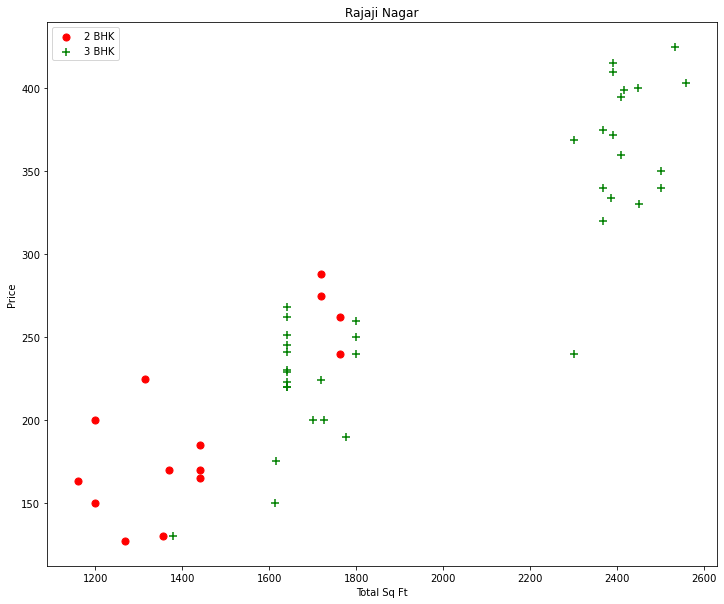

In [17]:
plot_price_based_on_bhk(df2, 'Rajaji Nagar')

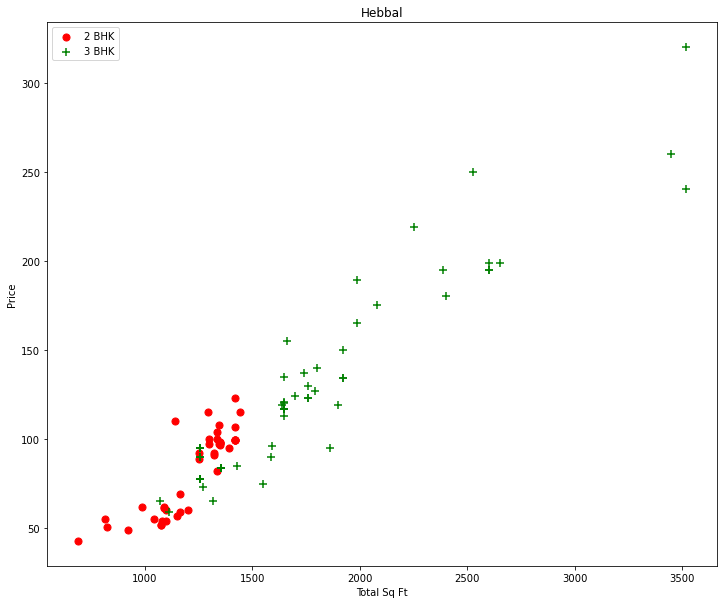

In [18]:
plot_price_based_on_bhk(df2, 'Hebbal')

#### All the records should be dropped where for same location the price for a N bhk is lesser than the price for a N-1 bhk property

* A dict can be utilised to group the data by number of bedrooms with their statistics like mean, std and count

In [29]:
def remove_bhk_outlier(df):
    exclude_indices = np.array([])
    
    for location, df_location in df.groupby('location'):
        bhk_stats = {}
        
        for bhk, df_bhk in df_location.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(df_bhk['price_per_sqft']),
                'std': np.std(df_bhk['price_per_sqft']),
                'count': df_bhk.shape[0]
            }
            
        for bhk, df_bhk in df_location.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, df_bhk[df_bhk['price_per_sqft'] < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [30]:
df3 = remove_bhk_outlier(df2)
df3.shape

(7324, 8)

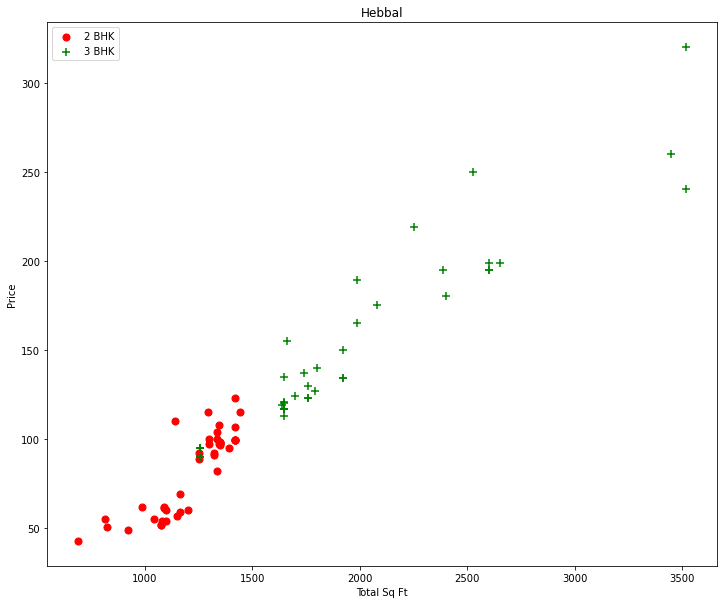

In [31]:
plot_price_based_on_bhk(df3, 'Hebbal')

#### Plotting a histogram to see the distribution of price_per_sqft

Text(0, 0.5, 'Count')

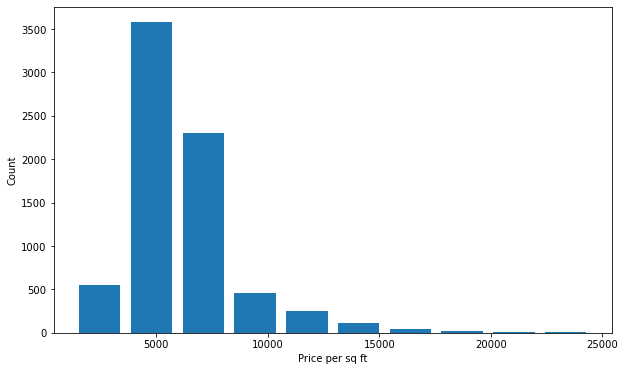

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(df3['price_per_sqft'], rwidth=0.8)
plt.xlabel('Price per sq ft')
plt.ylabel('Count')

#### From above it can be seen that for 0 - 10,000 price_per_sqft there are majority of data points, normally distributed.

### 4. In some cases there are large number of bathrooms available, this could indicate an anamoly.

- For example if a 2 BHK has 4 bathrooms, this is kind of an outlier... Usually the number of bathrooms should be less than equal to the number of bedrooms.
- Some houses with extremely large number of bedrooms can have large number of bathrooms

In [44]:
df3['bath'].unique()

array([ 4.,  3.,  2.,  5.,  1.,  8.,  6.,  7.,  9., 12., 16., 13.])

In [45]:
df3[df3['bath'] > 10]

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
5286,Neeladri Nagar,10 BHK,4000.0,12.0,2.0,160.0,10,4000.000000
8495,other,10 BHK,12000.0,12.0,2.0,525.0,10,4375.000000
8584,other,16 BHK,10000.0,16.0,2.0,550.0,16,5500.000000
9319,other,11 BHK,6000.0,12.0,2.0,150.0,11,2500.000000
9650,other,13 BHK,5425.0,13.0,0.0,275.0,13,5069.124424


#### Plotting a histogram to check the outliers for bathrooms

Text(0, 0.5, 'Count')

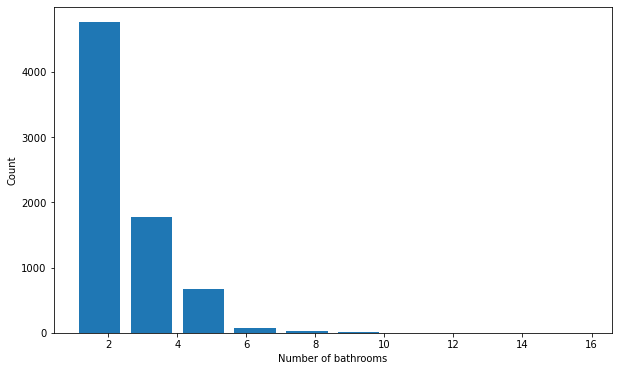

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(df3['bath'], rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

#### It can be seend that most of the houses have number of bathrooms less than 6, but there are some outliers present

* **Assumption** - If there are (number of bathrooms) greater than (2 + number of bedrooms), then the property can be considered as an outlier.

In [47]:
df3[df3['bath'] > (df3['bhk'] + 2)]

,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
1628,Chikkabanavar,4 Bedroom,2460.0,7.0,2.0,80.0,4,3252.032520
5247,Nagasandra,4 Bedroom,7000.0,8.0,2.0,450.0,4,6428.571429
6722,Thanisandra,3 BHK,1806.0,6.0,2.0,116.0,3,6423.034330
8420,other,6 BHK,11338.0,9.0,1.0,1000.0,6,8819.897689


##### The above 4 records are outliers based on the assumption, so these can be dropped

In [49]:
df4 = df3[~(df3['bath'] > (df3['bhk'] + 2))]
df4.shape

(7320, 8)

### Now the dataframe can be cleaned by dropping some features like "size", "price_per_sqft", as they don't add much value for training

##### The dataset can be saved for further usage in machine learning...

In [50]:
df5 = df4.drop(['size', 'price_per_sqft'], axis='columns')
df5.shape

(7320, 6)

In [51]:
df5.head()

,location,total_sqft,bath,balcony,price,bhk
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2


In [56]:
df5.to_csv('./data/processed_data.csv', index=False)

In [57]:
d = pd.read_csv('./data/processed_data.csv')

d.head()

,location,total_sqft,bath,balcony,price,bhk
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2
